In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



In [2]:
# Our handy function for converting our dataset into the correct format

def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number].values
        target = df.iloc[(i + window), target_col_number]
        #print(features)
        #print("----")
        #print(target)
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).astype(np.float64).reshape(-1, 1)

In [3]:
gc_df = pd.read_csv('zn1Data_big.csv', infer_datetime_format=True)
gc_df.set_index('Date', inplace=True)
gc_df.head(10)

,Unnamed: 0,RTDemand,DADemand,DALMP,DAEC,DACC,DAMLC,RTLMP,RTEC,RTCC,RTMLC,DryBulb,DewPoint,ZONE
Date,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,12055.0,11722.0,38.51,38.37,0.00,0.14,41.57,41.48,0.0,0.09,36.0,29.0,1
2011-01-01 01:00:00,1,11430.0,11253.0,36.86,36.75,0.00,0.11,34.91,34.82,0.0,0.09,36.0,29.0,1
2011-01-01 02:00:00,2,10966.0,10459.0,35.92,35.91,0.00,0.01,35.46,35.29,0.0,0.17,35.0,29.0,1
2011-01-01 03:00:00,3,10725.0,10531.0,35.94,35.91,0.00,0.03,34.14,33.97,0.0,0.17,35.0,30.0,1
2011-01-01 04:00:00,4,10672.0,10841.0,36.05,36.04,0.00,0.01,33.63,33.49,0.0,0.14,36.0,31.0,1
2011-01-01 05:00:00,5,10852.0,10661.0,36.05,36.12,0.00,-0.07,34.25,34.11,0.0,0.14,36.0,31.0,1
2011-01-01 06:00:00,6,11255.0,11640.0,37.29,37.51,0.00,-0.22,34.01,33.90,0.0,0.11,36.0,32.0,1
2011-01-01 07:00:00,7,11583.0,11972.0,37.97,38.68,0.00,-0.71,30.08,30.02,0.0,0.06,35.0,31.0,1
2011-01-01 08:00:00,8,12238.0,12735.0,39.36,44.27,-4.15,-0.76,32.28,32.23,0.0,0.05,35.0,32.0,1


In [4]:
gc_df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
gc_df['RTDemand'].replace(0.0, np.nan, inplace=True)
gc_df['RTDemand'].fillna(method='ffill', inplace=True)

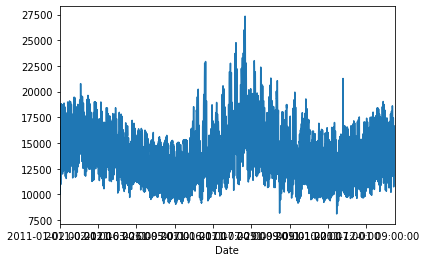

In [6]:
gc_df['RTDemand'][24:8760].plot()

In [7]:
gc_df.corr()
# heatmap next?

,RTDemand,DADemand,DALMP,DAEC,DACC,DAMLC,RTLMP,RTEC,RTCC,RTMLC,DryBulb,DewPoint,ZONE
RTDemand,1.000000,0.977080,0.442104,0.445661,-0.023751,0.152479,0.402194,0.408048,-0.034435,0.116079,0.205051,0.082827,NaN
DADemand,0.977080,1.000000,0.428871,0.432052,-0.022464,0.169525,0.362882,0.368052,-0.029625,0.108818,0.214733,0.093497,NaN
DALMP,0.442104,0.428871,1.000000,0.997859,0.031291,0.776977,0.782653,0.779834,0.115018,0.759487,-0.397712,-0.432217,NaN
DAEC,0.445661,0.432052,0.997859,1.000000,-0.033794,0.772423,0.781217,0.778614,0.111314,0.754186,-0.395775,-0.431202,NaN
DACC,-0.023751,-0.022464,0.031291,-0.033794,1.000000,0.003497,0.022644,0.020200,0.046754,0.042897,-0.009420,-0.000134,NaN
DAMLC,0.152479,0.169525,0.776977,0.772423,0.003497,1.000000,0.597040,0.589553,0.149013,0.816285,-0.428603,-0.425758,NaN
RTLMP,0.402194,0.362882,0.782653,0.781217,0.022644,0.597040,1.000000,0.998726,0.142540,0.752172,-0.296412,-0.309828,NaN
RTEC,0.408048,0.368052,0.779834,0.778614,0.020200,0.589553,0.998726,1.000000,0.092802,0.742827,-0.291708,-0.305749,NaN
RTCC,-0.034435,-0.029625,0.115018,0.111314,0.046754,0.149013,0.142540,0.092802,1.000000,0.191479,-0.084378,-0.077857,NaN
RTMLC,0.116079,0.108818,0.759487,0.754186,0.042897,0.816285,0.752172,0.742827,0.191479,1.000000,-0.453785,-0.440923,NaN


In [8]:
#gc_df = gc_df.head(500) # Tiny dataset to be sure the models all compile/run!

In [9]:
window_size = 72 # 3 days

(X, y) = window_data(gc_df, window_size, 0, 0)

In [10]:
y.shape


(77346, 1)

In [11]:
X.shape

(77346, 72)

In [12]:
(dry_bulb, _) = window_data(gc_df, window_size, 10, 1)
(dew_pt, _) = window_data(gc_df, window_size, 11, 1)
(DADemand, _) = window_data(gc_df, window_size, 1, 1)
(DALMP, _) = window_data(gc_df, window_size, 2, 1)
(DAEC, _) = window_data(gc_df, window_size, 3, 1)
(DACC, _) = window_data(gc_df, window_size, 4, 1)
(DAMLC, _) = window_data(gc_df, window_size, 5, 1)
(RTLMP, _) = window_data(gc_df, window_size, 6, 1)
(RTEC, _) = window_data(gc_df, window_size, 7, 1)
(RTCC, _) = window_data(gc_df, window_size, 8, 1)
(RTMLC, _) = window_data(gc_df, window_size, 9, 1)

In [13]:
dew_pt[0]

array([29., 29., 29., 30., 31., 31., 32., 31., 32., 34., 35., 37., 38.,
       39., 39., 38., 37., 37., 37., 36., 37., 38., 38., 40., 41., 41.,
       41., 41., 42., 42., 42., 42., 41., 42., 43., 43., 43., 43., 42.,
       42., 39., 38., 35., 33., 31., 28., 26., 23., 21., 19., 17., 16.,
       15., 15., 13., 12., 12., 11., 11., 10., 10., 10., 10.,  9., 10.,
       10., 11., 11., 11., 12., 12., 12.])

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
dry_bulb = scaler.fit_transform(dry_bulb)
dew_pt = scaler.fit_transform(dew_pt)

DADemand = scaler.fit_transform(DADemand)
DALMP = scaler.fit_transform(DALMP)
DAEC = scaler.fit_transform(DAEC)
DACC = scaler.fit_transform(DACC)
DAMLC = scaler.fit_transform(DAMLC)
RTLMP = scaler.fit_transform(RTLMP)
RTEC = scaler.fit_transform(RTEC)
RTCC = scaler.fit_transform(RTCC)
RTMLC = scaler.fit_transform(RTMLC)


DADemand
DALMP
DAEC
DACC
DAMLC
RTLMP
RTEC
RTCC
RTMLC

In [15]:
split = int(0.8 * len(X))
X_train = X[: split - 1]
X_test = X[split:]

db_train = dry_bulb[: split - 1]
db_test = dry_bulb[split:]

dew_train = dew_pt[: split - 1]
dew_test = dew_pt[split:]

y_train = y[: split - 1]
y_test = y[split:]

DADemand_train = DADemand[: split - 1]
DALMP_train = DALMP[: split - 1]
DAEC_train = DAEC[: split - 1]
DACC_train = DACC[: split - 1]
DAMLC_train = DAMLC[: split - 1]
RTLMP_train = RTLMP[: split - 1]
RTEC_train = RTEC[: split - 1]
RTCC_train = RTCC[: split - 1]
RTMLC_train = RTMLC[: split - 1]

DADemand_test = DADemand[split:]
DALMP_test = DALMP[split:]
DAEC_test = DAEC[split:]
DACC_test = DACC[split:]
DAMLC_test = DAMLC[split:]
RTLMP_test = RTLMP[split:]
RTEC_test = RTEC[split:]
RTCC_test = RTCC[split:]
RTMLC_test = RTMLC[split:]




X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
db_train = db_train.reshape((db_train.shape[0], db_train.shape[1], 1))
dew_train = dew_train.reshape((dew_train.shape[0], dew_train.shape[1], 1))
DADemand_train = DADemand_train.reshape((DADemand_train.shape[0], DADemand_train.shape[1], 1))
DALMP_train = DALMP_train.reshape((DALMP_train.shape[0], DALMP_train.shape[1], 1))
DAEC_train = DAEC_train.reshape((DAEC_train.shape[0], DAEC_train.shape[1], 1))
DACC_train = DACC_train.reshape((DACC_train.shape[0], DACC_train.shape[1], 1))
DAMLC_train = DAMLC_train.reshape((DAMLC_train.shape[0], DAMLC_train.shape[1], 1))
RTLMP_train = RTLMP_train.reshape((RTLMP_train.shape[0], RTLMP_train.shape[1], 1))
RTEC_train = RTEC_train.reshape((RTEC_train.shape[0], RTEC_train.shape[1], 1))
RTCC_train = RTCC_train.reshape((RTCC_train.shape[0], RTCC_train.shape[1], 1))
RTMLC_train = RTMLC_train.reshape((RTMLC_train.shape[0], RTMLC_train.shape[1], 1))
data_train = np.concatenate((X_train, db_train, dew_train, DADemand_train, DALMP_train, DAEC_train, DACC_train, DAMLC_train, RTLMP_train, RTEC_train, RTCC_train, RTMLC_train), axis=2)
#data_train = np.concatenate((X_train, DADemand_train), axis=2)


X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
db_test = db_test.reshape((db_test.shape[0], db_test.shape[1], 1))
dew_test = dew_test.reshape((dew_test.shape[0], dew_test.shape[1], 1))
DADemand_test = DADemand_test.reshape((DADemand_test.shape[0], DADemand_test.shape[1], 1))
DALMP_test = DALMP_test.reshape((DALMP_test.shape[0], DALMP_test.shape[1], 1))
DAEC_test = DAEC_test.reshape((DAEC_test.shape[0], DAEC_test.shape[1], 1))
DACC_test = DACC_test.reshape((DACC_test.shape[0], DACC_test.shape[1], 1))
DAMLC_test = DAMLC_test.reshape((DAMLC_test.shape[0], DAMLC_test.shape[1], 1))
RTLMP_test = RTLMP_test.reshape((RTLMP_test.shape[0], RTLMP_test.shape[1], 1))
RTEC_test = RTEC_test.reshape((RTEC_test.shape[0], RTEC_test.shape[1], 1))
RTCC_test = RTCC_test.reshape((RTCC_test.shape[0], RTCC_test.shape[1], 1))
RTMLC_test = RTMLC_test.reshape((RTMLC_test.shape[0], RTMLC_test.shape[1], 1))
data_test = np.concatenate((X_test, db_test, dew_test, DADemand_test, DALMP_test, DAEC_test, DACC_test, DAMLC_test, RTLMP_test, RTEC_test, RTCC_test, RTMLC_test), axis=2)
#data_test = np.concatenate((X_test, DADemand_test), axis=2)



In [16]:
X_train.shape

(61875, 72, 1)

## How about a 1-variable LSTM?

In [26]:
def basic_LSTM(window_size=5, n_features=1):
    new_model = keras.Sequential()
    new_model.add(tf.keras.layers.LSTM(100, input_shape=(window_size, n_features), activation='relu'))
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(1500, activation='relu'))
    new_model.add(tf.keras.layers.Dense(100, activation='linear'))
    new_model.add(tf.keras.layers.Dense(1))
    new_model.compile(optimizer="adam", loss="mean_squared_error")    
    return new_model

In [27]:
ls_model = basic_LSTM(window_size=window_size, n_features=X_train.shape[2])

In [28]:
ls_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1500)              151500    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               150100    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 342,501
Trainable params: 342,501
Non-trainable params: 0
_________________________________________________________________


In [29]:
ls_history = ls_model.fit(X_train ,y_train, epochs=10, shuffle=False, batch_size=100, verbose=1)

Train on 61875 samples
Epoch 1/10
16600/61875 [=======>......................] - ETA: 33s - loss: nan

KeyboardInterrupt: 

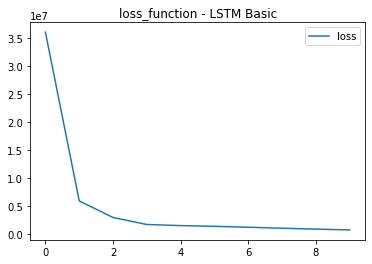

In [21]:
plt.plot(ls_history.history["loss"])
plt.title("loss_function - LSTM Basic")
plt.legend(["loss"])
plt.show()

In [22]:
ls_model.evaluate(X_test, y_test, verbose=0)

1174830.0587427279

In [23]:
from sklearn.metrics import r2_score
predictions = ls_model.predict(X_test)
test_r2 = r2_score(y_test, predictions)
test_r2

0.8451637094740732

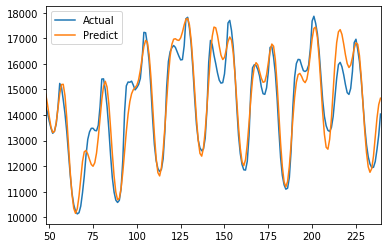

In [24]:
lstm_acc_df = pd.DataFrame()
lstm_acc_df['Actual'] = y_test[:,0]
lstm_acc_df['Predict'] = predictions[:,0]
lstm_acc_df[48:240].plot()

# 1D Convolution with 1 variable


In [24]:
def basic_conv1D(n_filters=10, fsize=5, window_size=5, n_features=2):
    new_model = keras.Sequential()
    # Hypothetically, we could also tune the padding and activation here.
    new_model.add(tf.keras.layers.Conv1D(n_filters, fsize, padding="same", activation="relu", input_shape=(window_size, n_features)))
    # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(1800, activation='relu'))
    new_model.add(tf.keras.layers.Dense(100))
    new_model.add(tf.keras.layers.Dense(1))
    new_model.compile(optimizer="adam", loss="mean_squared_error")    
    return new_model


In [25]:
univar_model = basic_conv1D(n_filters=24, fsize=8, window_size=window_size, n_features=X_train.shape[2])

In [26]:
univar_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 72, 24)            216       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1800)              3112200   
_________________________________________________________________
dense_4 (Dense)              (None, 100)               180100    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 3,292,617
Trainable params: 3,292,617
Non-trainable params: 0
_________________________________________________________________


In [27]:
univar_hist = univar_model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=10, verbose=1)

Train on 61875 samples
Epoch 1/10
61875/61875 [==============================] - 110s 2ms/sample - loss: 3373622.6293
Epoch 2/10
61875/61875 [==============================] - 109s 2ms/sample - loss: 903452.3404
Epoch 3/10
61875/61875 [==============================] - 109s 2ms/sample - loss: 594056.2459
Epoch 4/10
61875/61875 [==============================] - 110s 2ms/sample - loss: 430210.8427
Epoch 5/10
61875/61875 [==============================] - 109s 2ms/sample - loss: 352022.9304
Epoch 6/10
61875/61875 [==============================] - 109s 2ms/sample - loss: 299500.0900
Epoch 7/10
61875/61875 [==============================] - 110s 2ms/sample - loss: 248175.8128
Epoch 8/10
61875/61875 [==============================] - 109s 2ms/sample - loss: 211657.6709
Epoch 9/10
61875/61875 [==============================] - 111s 2ms/sample - loss: 191893.8157
Epoch 10/10
61875/61875 [==============================] - 109s 2ms/sample - loss: 174983.3995


In [28]:
#y_train

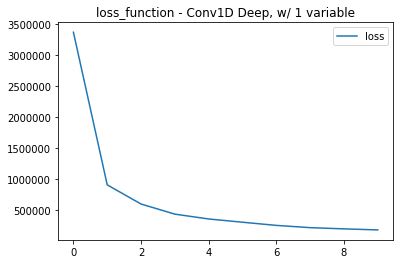

In [29]:
plt.plot(univar_hist.history["loss"])
plt.title("loss_function - Conv1D Deep, w/ 1 variable")
plt.legend(["loss"])

plt.show()

In [30]:
univar_model.evaluate(X_test, y_test, verbose=0)

921088.9656229799

In [31]:
from sklearn.metrics import r2_score
predictions = univar_model.predict(X_test)
test_r2 = r2_score(y_test, predictions)
test_r2

0.8786054224398805

In [32]:
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test[:,0]
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

,Actual,Predict
0,16092.869,15189.262695
1,15745.950,14561.523438
2,15488.247,14086.809570
3,15252.608,13980.620117
4,15253.593,13994.477539
5,15363.811,14063.493164
6,15835.579,14401.088867
7,16778.363,15448.152344
8,18007.694,16595.259766
9,18130.813,16833.191406


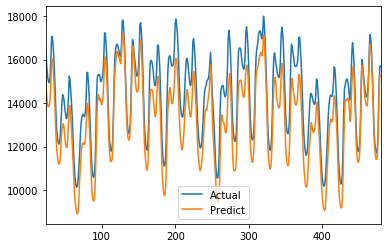

In [33]:
conv_acc_df[24:480].plot()

## Multi-variate 1D conv net:

In [92]:
data_train.shape

(61875, 72, 12)

In [34]:
test_model = basic_conv1D(n_filters=25, fsize=8, window_size=window_size, n_features=data_train.shape[2])

In [35]:
test_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 72, 25)            2425      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1800)              3241800   
_________________________________________________________________
dense_7 (Dense)              (None, 100)               180100    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 3,424,426
Trainable params: 3,424,426
Non-trainable params: 0
_________________________________________________________________


In [36]:
train_history = test_model.fit(data_train, y_train, epochs=10, shuffle=False, batch_size=10, verbose=1)

Train on 61875 samples
Epoch 1/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 6757805.7699
Epoch 2/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 2430849.9738
Epoch 3/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 1534002.6363
Epoch 4/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 883716.0229
Epoch 5/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 762074.4609
Epoch 6/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 593377.1990
Epoch 7/10
61875/61875 [==============================] - 111s 2ms/sample - loss: 505852.3352
Epoch 8/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 420105.5836
Epoch 9/10
61875/61875 [==============================] - 111s 2ms/sample - loss: 381965.5248
Epoch 10/10
61875/61875 [==============================] - 112s 2ms/sample - loss: 392245.8856


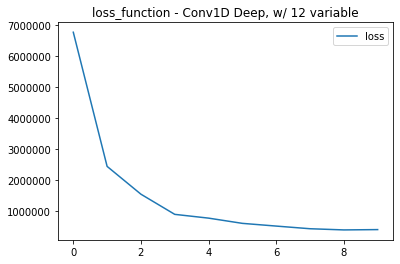

In [37]:
plt.plot(train_history.history["loss"])
plt.title("loss_function - Conv1D Deep, w/ 12 variable")
plt.legend(["loss"])

plt.show()

In [38]:
#X_test

In [39]:
#y_test

In [40]:
test_model.evaluate(data_test, y_test, verbose=0)

1190440.5917905623

In [41]:
from sklearn.metrics import r2_score
predictions = test_model.predict(data_test)
test_r2 = r2_score(y_test, predictions)
test_r2

0.8431063253046929

In [42]:
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test[:,0]
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

,Actual,Predict
0,16092.869,17164.814453
1,15745.950,17168.632812
2,15488.247,17025.683594
3,15252.608,16717.927734
4,15253.593,16480.197266
5,15363.811,16336.948242
6,15835.579,16719.464844
7,16778.363,17872.382812
8,18007.694,18845.275391
9,18130.813,18925.900391


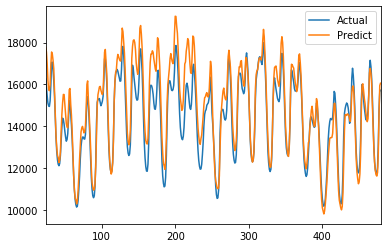

In [43]:
conv_acc_df[24:480].plot()


## Multi-variate LSTM

In [97]:
ls_model = basic_LSTM(window_size=window_size, n_features=data_train.shape[2])

In [98]:
ls_model.summary()
# Note: if we're getting nan here, re-check the dataset to see if we're getting any bad data there


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 72, 100)           45200     
_________________________________________________________________
flatten_7 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1500)              10801500  
_________________________________________________________________
dense_22 (Dense)             (None, 100)               150100    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 10,996,901
Trainable params: 10,996,901
Non-trainable params: 0
_________________________________________________________________


In [99]:
# This will be true if data_train has any nans
summa = np.sum(data_train)
check_nan = np.isnan(summa)
check_nan

False

In [103]:
ls_history = ls_model.fit(data_train ,y_train, epochs=10, shuffle=False, batch_size=100, verbose=1)

Train on 61875 samples
Epoch 1/10
61875/61875 [==============================] - 98s 2ms/sample - loss: 17353243.5944
Epoch 2/10
61875/61875 [==============================] - 102s 2ms/sample - loss: 3894199.4620
Epoch 3/10
61875/61875 [==============================] - 104s 2ms/sample - loss: 2039165.5416
Epoch 4/10
61875/61875 [==============================] - 104s 2ms/sample - loss: 1440865.4328
Epoch 5/10
61875/61875 [==============================] - 108s 2ms/sample - loss: 1172870.2937
Epoch 6/10
61875/61875 [==============================] - 106s 2ms/sample - loss: 1497879.3899
Epoch 7/10
61875/61875 [==============================] - 100s 2ms/sample - loss: 1344339.4115
Epoch 8/10
61875/61875 [==============================] - 103s 2ms/sample - loss: 1321593.1008
Epoch 9/10
61875/61875 [==============================] - 104s 2ms/sample - loss: 1539892.5339
Epoch 10/10
61875/61875 [==============================] - 104s 2ms/sample - loss: 1360416.4545


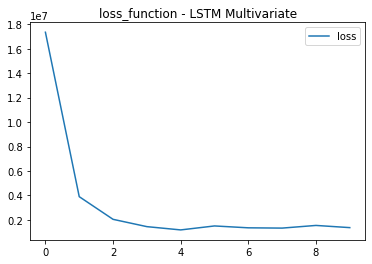

In [104]:
plt.plot(ls_history.history["loss"])
plt.title("loss_function - LSTM Multivariate")
plt.legend(["loss"])
plt.show()

In [107]:

test = ls_model.evaluate(data_test, y_test, verbose=0)
if(not np.isnan(test)):
    print(test)
else:
    print("nan failure. :(")

1439643.2088255493


In [108]:

if(not np.isnan(test)):
    from sklearn.metrics import r2_score
    predictions = ls_model.predict(data_test)
    test_r2 = r2_score(y_test, predictions)
    print(test_r2)

0.8102627579239303


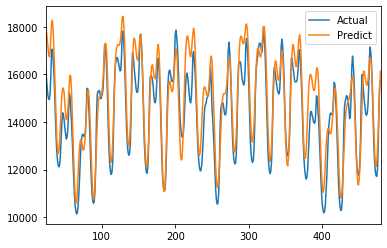

In [109]:
if(not np.isnan(test)):
    lstm_acc_df = pd.DataFrame()
    lstm_acc_df['Actual'] = y_test[:,0]
    lstm_acc_df['Predict'] = predictions[:,0]
    lstm_acc_df[24:480].plot()

## CONV 2D: Game changer
Here we create a conv2d with a filter shape of 1 timestep by fsize features, basically turning the convolution window on the Z-axis in our slides. 




In [58]:
def basic_conv2D(n_filters=10, fsize=5, window_size=5, n_features=2):
    new_model = keras.Sequential()
    # Hypothetically, we could also tune the padding and activation here.
    new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
    # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(1000, activation='relu'))
    new_model.add(tf.keras.layers.Dense(100))
    new_model.add(tf.keras.layers.Dense(1))
    new_model.compile(optimizer="adam", loss="mean_squared_error")    
    return new_model

In [59]:
data_train_wide = data_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2], 1))
data_test_wide = data_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2], 1))

In [60]:
data_train_wide.shape

(61875, 72, 12, 1)

In [61]:
m2 = basic_conv2D(n_filters=24, fsize=2, window_size=window_size, n_features=data_train_wide.shape[2])

In [62]:
m2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 12, 24)        72        
_________________________________________________________________
flatten_4 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              20737000  
_________________________________________________________________
dense_13 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 20,837,273
Trainable params: 20,837,273
Non-trainable params: 0
_________________________________________________________________


In [63]:
m2_hist = m2.fit(data_train_wide, y_train, epochs=10)

Train on 61875 samples
Epoch 1/10
61875/61875 [==============================] - 239s 4ms/sample - loss: 3333101.1274
Epoch 2/10
61875/61875 [==============================] - 234s 4ms/sample - loss: 300454.4922
Epoch 3/10
61875/61875 [==============================] - 258s 4ms/sample - loss: 234770.6481
Epoch 4/10
61875/61875 [==============================] - 291s 5ms/sample - loss: 185101.6956
Epoch 5/10
61875/61875 [==============================] - 297s 5ms/sample - loss: 161944.8792
Epoch 6/10
61875/61875 [==============================] - 275s 4ms/sample - loss: 143251.4362
Epoch 7/10
61875/61875 [==============================] - 236s 4ms/sample - loss: 127758.4972
Epoch 8/10
61875/61875 [==============================] - 268s 4ms/sample - loss: 119297.8298
Epoch 9/10
61875/61875 [==============================] - 243s 4ms/sample - loss: 112657.1073
Epoch 10/10
61875/61875 [==============================] - 234s 4ms/sample - loss: 108458.5306


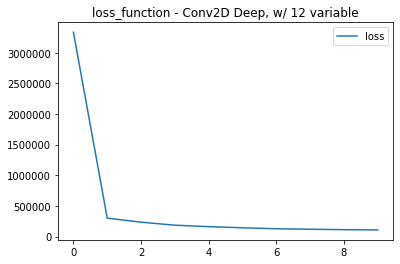

In [64]:
plt.plot(m2_hist.history["loss"])
plt.title("loss_function - Conv2D Deep, w/ 12 variable")
plt.legend(["loss"])
# 
plt.show()

In [65]:
m2.evaluate(data_test_wide, y_test, verbose=0)

68627.36885150695

In [66]:
from sklearn.metrics import r2_score
predictions = m2.predict(data_test_wide)
test_r2 = r2_score(y_test, predictions)
test_r2

0.9909552814481323

In [67]:
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test[:,0]
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

,Actual,Predict
0,16092.869,16453.220703
1,15745.950,16298.168945
2,15488.247,15888.483398
3,15252.608,15474.940430
4,15253.593,15228.213867
5,15363.811,15060.584961
6,15835.579,15249.165039
7,16778.363,16405.300781
8,18007.694,17606.994141
9,18130.813,18313.033203


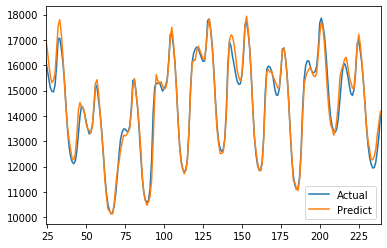

In [68]:
conv_acc_df[24:240].plot()

# Deeper conv2D



I convolved over 2-feature/1-timestep, now I want to convolve over 1-feature/8-timestep, but the 1-feature is actually a 2-feature convolution. 

<img src="resources/deeper.jpg">



In [69]:
def deeper_conv2D(n_filters=10, fsize=5, window_size=5, n_features=2, hour_filter=8):
    new_model = keras.Sequential()
    new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="linear", input_shape=(window_size, n_features, 1)))
    new_model.add(tf.keras.layers.Conv2D(n_filters, (hour_filter, 1), padding="same", activation="relu"))
    # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(1000, activation='relu'))
    new_model.add(tf.keras.layers.Dense(100))
    new_model.add(tf.keras.layers.Dense(1))
    new_model.compile(optimizer="adam", loss="mean_squared_error")    
    return new_model

In [70]:
m3 = deeper_conv2D(n_filters=24, fsize=2, window_size=window_size, n_features=data_train_wide.shape[2], hour_filter=8)

In [71]:
m3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 12, 24)        72        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 12, 24)        4632      
_________________________________________________________________
flatten_5 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1000)              20737000  
_________________________________________________________________
dense_16 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 20,841,905
Trainable params: 20,841,905
Non-trainable params: 0
__________________________________________

In [72]:
m3_hist = m3.fit(data_train_wide, y_train, epochs=10)

Train on 61875 samples
Epoch 1/10
61875/61875 [==============================] - 270s 4ms/sample - loss: 2702396.0686
Epoch 2/10
61875/61875 [==============================] - 260s 4ms/sample - loss: 259545.2844
Epoch 3/10
61875/61875 [==============================] - 275s 4ms/sample - loss: 208541.9392
Epoch 4/10
61875/61875 [==============================] - 276s 4ms/sample - loss: 145264.1884
Epoch 5/10
61875/61875 [==============================] - 266s 4ms/sample - loss: 126733.4120
Epoch 6/10
61875/61875 [==============================] - 277s 4ms/sample - loss: 107967.2880
Epoch 7/10
61875/61875 [==============================] - 265s 4ms/sample - loss: 99217.9270
Epoch 8/10
61875/61875 [==============================] - 268s 4ms/sample - loss: 83188.1179
Epoch 9/10
61875/61875 [==============================] - 270s 4ms/sample - loss: 79428.3213
Epoch 10/10
61875/61875 [==============================] - 282s 5ms/sample - loss: 75911.6892


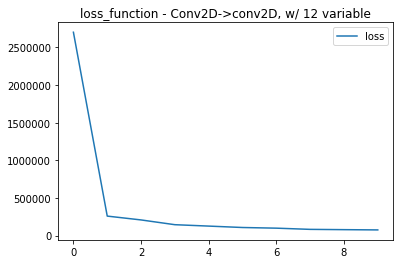

In [73]:
plt.plot(m3_hist.history["loss"])
plt.title("loss_function - Conv2D->conv2D, w/ 12 variable")
plt.legend(["loss"])
# 
plt.show()

In [74]:
m3.evaluate(data_test_wide, y_test, verbose=0)

47929.50422238607

In [75]:
from sklearn.metrics import r2_score
predictions = m3.predict(data_test_wide)
test_r2 = r2_score(y_test, predictions)
test_r2

0.9936831487638945

In [76]:
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test[:,0]
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

,Actual,Predict
0,16092.869,16398.658203
1,15745.950,15983.678711
2,15488.247,15390.015625
3,15252.608,15160.970703
4,15253.593,15124.511719
5,15363.811,15215.758789
6,15835.579,15586.958008
7,16778.363,16709.880859
8,18007.694,17714.212891
9,18130.813,17939.414062


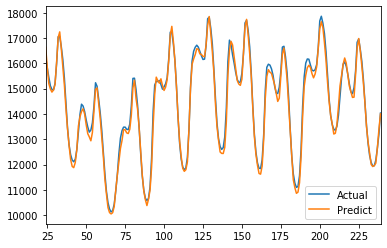

In [77]:
conv_acc_df[24:240].plot()

## How does it do vs dumb model?

Here, my dumb model is to simply predict the previous value as the next value.


In [78]:
# Dumb model
prev_val = y_test[0]
sse = 0

for n in range(0, len(y_test)-1):
    err = y_test[n] - prev_val
    sq_err = err ** 2
    sse = sse + sq_err
    prev_val = y_test[n]

mse = sse / n
mse


array([411577.17812475])

In [17]:
predict = pd.DataFrame(y_test, columns = ["dumb_predict"])
predict = predict.shift(1)
predict["actual"] = y_test
predict.fillna(value=0, inplace=True)
correct_cols = ["actual", "dumb_predict"]
predict = predict.reindex(columns=correct_cols)
predict


,actual,dumb_predict
0,16092.869,0.000
1,15745.950,16092.869
2,15488.247,15745.950
3,15252.608,15488.247
4,15253.593,15252.608
...,...,...
15465,14342.179,14399.190
15466,13908.957,14342.179
15467,13504.615,13908.957
15468,12695.970,13504.615


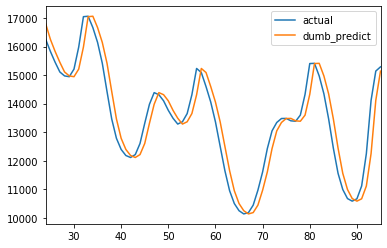

In [18]:
predict[24:96].plot()

In [81]:
from sklearn.metrics import r2_score
predictions = predict["dumb_predict"].values
test_r2 = r2_score(y_test, predictions)
test_r2

0.9435487010187062